## Compare Multi Quantum Feature Map

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import pennylane as qml
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("../")
from src.utils import plot_dataset, plot_predicted_result, plot_decisionon_boundaries, plot_metrics
from src.feature_map import xx_feature_map, zz_feature_map, angle_feature_map
from src.kernel import compute_kernel, kernel, evaluate_kernel
from src.schema import KernelParams, Dataset

In [12]:
RANDOM_STATE = 42
SAVE_IMG_DIRC = "../data/images/iris/zz_feature_map"
feature_map_list = [xx_feature_map, zz_feature_map, angle_feature_map]
FEATURE_MAP = feature_map_list[1]

# Seeting of Quantum Device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

### 1. Load Iris Dataset

In [13]:
iris_dataset = datasets.load_iris(as_frame=True)
iris_df = iris_dataset.frame
print(f"Dataset Shape: {iris_df.shape}")
print(f"Unique Target Classes: {iris_df['target'].nunique()}")
print(f"Target Classes: {iris_df['target'].unique()}")

iris_df.head()

Dataset Shape: (150, 5)
Unique Target Classes: 3
Target Classes: [0 1 2]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [14]:
target_class = [0, 1]  # ['setosa', 'versicolor', 'virginica']
iris_df = iris_df[iris_df["target"].isin(target_class)]

# feature_cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
feature_cols = ['sepal length (cm)', 'sepal width (cm)']
# feature_cols = ['petal length (cm)', 'petal width (cm)']

X = iris_df.loc[:, feature_cols].to_numpy()
y = iris_df["target"].to_numpy()

In [15]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y_scaled = 2 * (y - 0.5)  # convert label to -1, 1

x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.25, random_state=RANDOM_STATE
)

dataset = Dataset(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    feature_cols=feature_cols,
    target_col="target")

print(f"X train shape: {x_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (75, 2)
X test shape: (25, 2)
y train shape: (75,)
y test shape: (25,)


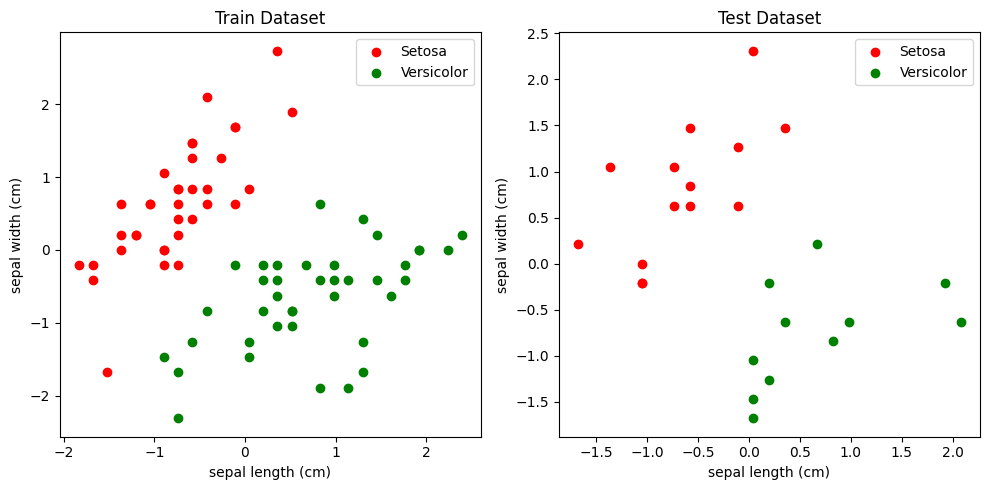

In [16]:
class_labels = {-1: 'Setosa', 1: 'Versicolor'}
plot_dataset(dataset, class_labels=class_labels)

### 2. Compute the kernel matrix

In [17]:
@qml.qnode(dev)
def kernel_with_qnode(x1, x2, kernel_params):
    return kernel(x1, x2, kernel_params)

In [10]:
kernel_params = KernelParams(
    n_qubits=n_qubits,
    feature_map=FEATURE_MAP,
    reps=3,
    kernel=kernel_with_qnode,
    rotaion_axis=None
)

In [44]:
train_kernel = compute_kernel(x_train, x_train, kernel_params)
test_kernel = compute_kernel(x_test, x_train, kernel_params)

print(f"Train Kernel Matrix Shape: {train_kernel.shape}")
print(f"Test Kernel Matrix Shape: {test_kernel.shape}")

print(qml.draw(kernel)(x_train[0], x_train[1], kernel_params))

100%|██████████| 25/25 [00:01<00:00, 14.85it/s]


Train Kernel Matrix Shape: (75, 75)
Test Kernel Matrix Shape: (25, 75)
0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M0)─╭AngleEmbedding(M0)─╭AngleEmbedding(M1)†
1: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M0)─╰AngleEmbedding(M0)─╰AngleEmbedding(M1)†

──╭AngleEmbedding(M1)†─╭AngleEmbedding(M1)†─┤ ╭Probs
──╰AngleEmbedding(M1)†─╰AngleEmbedding(M1)†─┤ ╰Probs
M0 = 
[0.35866332 2.73124718]
M1 = 
[-0.73768744  0.84183714]


### 3. Train and Predict QSVM

In [45]:
model = SVC(kernel="precomputed")
model.fit(train_kernel, y_train)

start_time = time.time()
y_pred = model.predict(test_kernel)
end_time = time.time()
pred_time = (end_time - start_time) / test_kernel.shape[0]
print(f"Prediction time: {pred_time:.2f} [s/instance]")

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Prediction time: 0.00 [s/instance]
Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.80      0.57      0.67        14
         1.0       0.60      0.82      0.69        11

    accuracy                           0.68        25
   macro avg       0.70      0.69      0.68        25
weighted avg       0.71      0.68      0.68        25


Confusion Matrix:
 [[8 6]
 [2 9]]


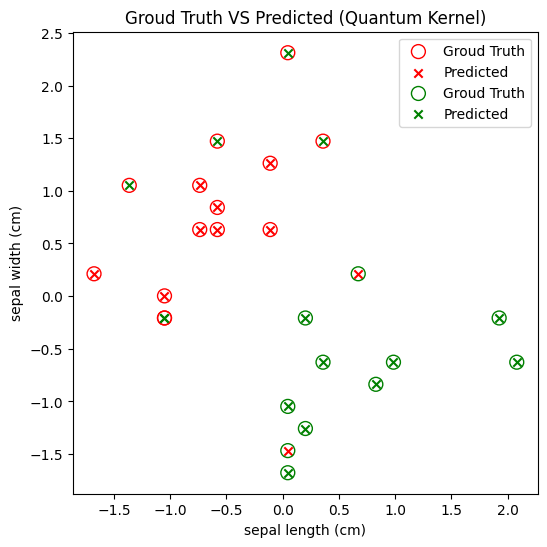

In [46]:
plot_predicted_result(dataset, y_pred, save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_predict.png")

Calculating Kernel Matrix for 2400 mesh points


100%|██████████| 2400/2400 [02:43<00:00, 14.65it/s]


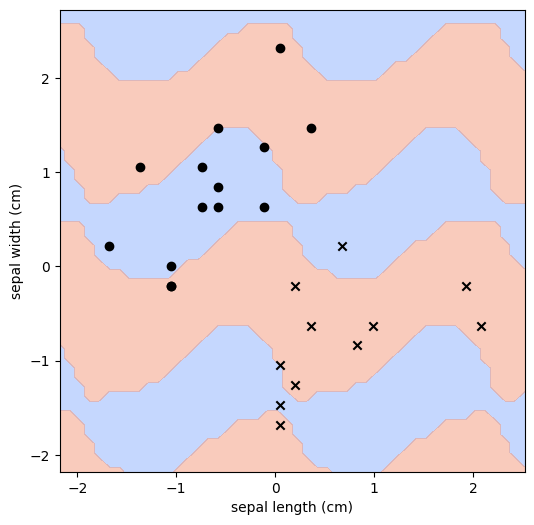

In [38]:
plot_decisionon_boundaries(
    model, 
    dataset,
    kernel_params,
    step_size=0.1, 
    save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_boundary.png"
)

In [47]:
_, _ = evaluate_kernel(x_train, y_train, kernel_params)

Target Kernel Alignment: 0.04
Kernel Polarity: 0.06


### 4. Batch Prediction

******************* 1 *******************


100%|██████████| 25/25 [00:01<00:00, 22.11it/s]


Accuracy: 1.0
Calculating Kernel Matrix for 2400 mesh points


100%|██████████| 2400/2400 [01:47<00:00, 22.30it/s]


Target Kernel Alignment: 0.23
Kernel Polarity: 0.34
******************* 2 *******************


100%|██████████| 25/25 [00:01<00:00, 13.67it/s]


Accuracy: 0.56
Calculating Kernel Matrix for 2400 mesh points


100%|██████████| 2400/2400 [02:56<00:00, 13.61it/s]


Target Kernel Alignment: 0.05
Kernel Polarity: 0.08
******************* 3 *******************


100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Accuracy: 0.8
Calculating Kernel Matrix for 2400 mesh points


100%|██████████| 2400/2400 [04:05<00:00,  9.76it/s]


Target Kernel Alignment: 0.07
Kernel Polarity: 0.10
******************* 4 *******************


100%|██████████| 25/25 [00:03<00:00,  7.72it/s]


Accuracy: 0.56
Calculating Kernel Matrix for 2400 mesh points


100%|██████████| 2400/2400 [05:07<00:00,  7.81it/s]


Target Kernel Alignment: 0.04
Kernel Polarity: 0.08
******************* 5 *******************


100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Accuracy: 0.76
Calculating Kernel Matrix for 2400 mesh points


100%|██████████| 2400/2400 [06:13<00:00,  6.42it/s]


Target Kernel Alignment: 0.04
Kernel Polarity: 0.08


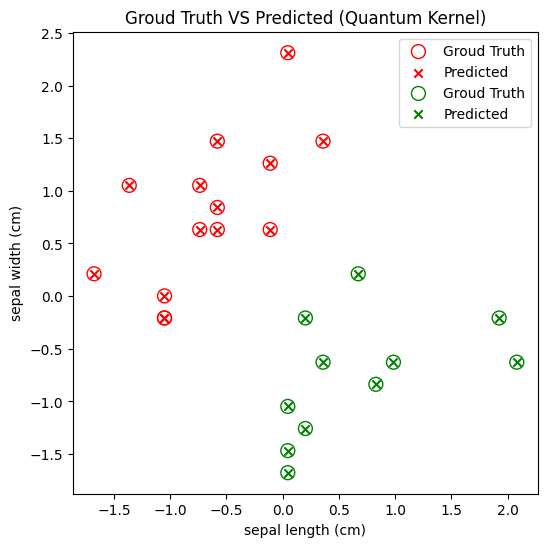

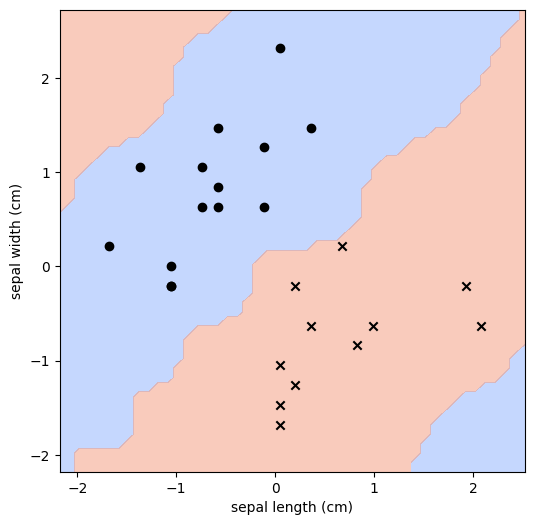

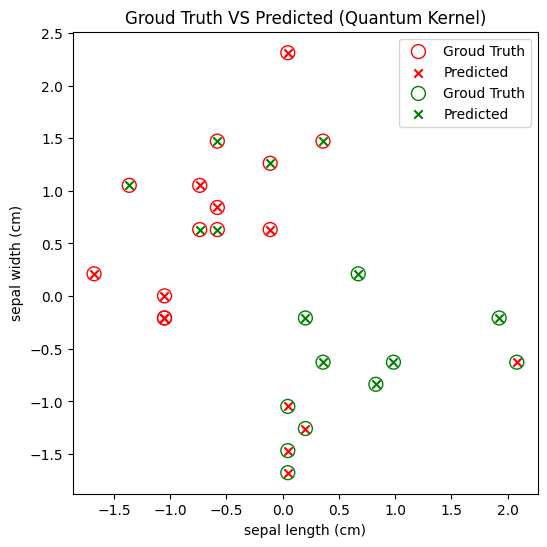

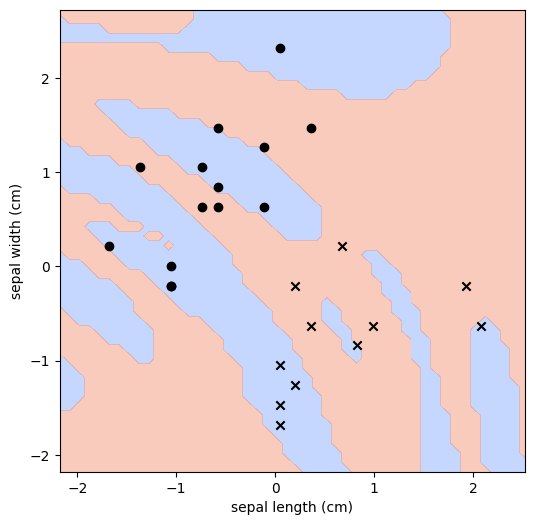

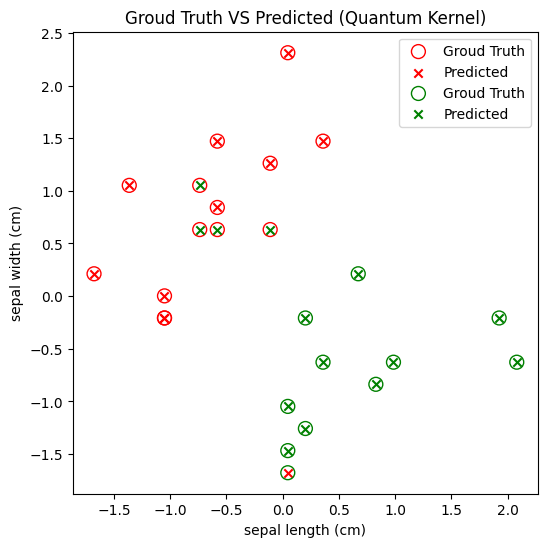

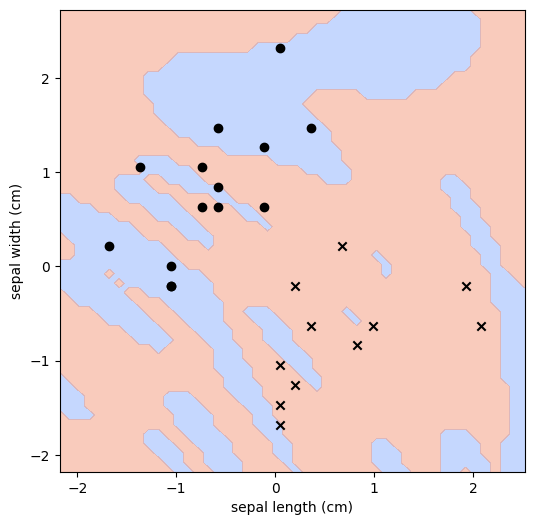

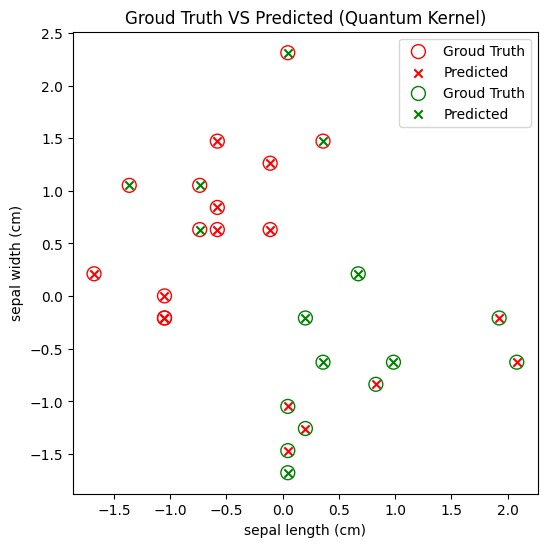

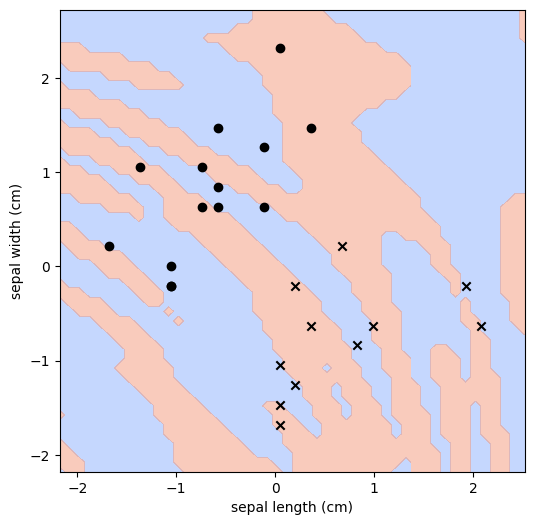

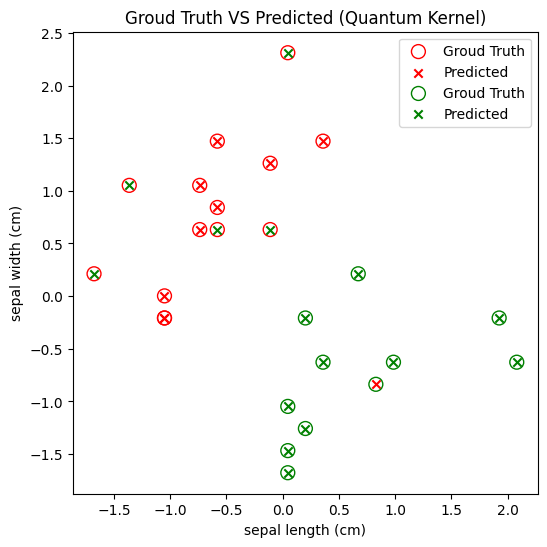

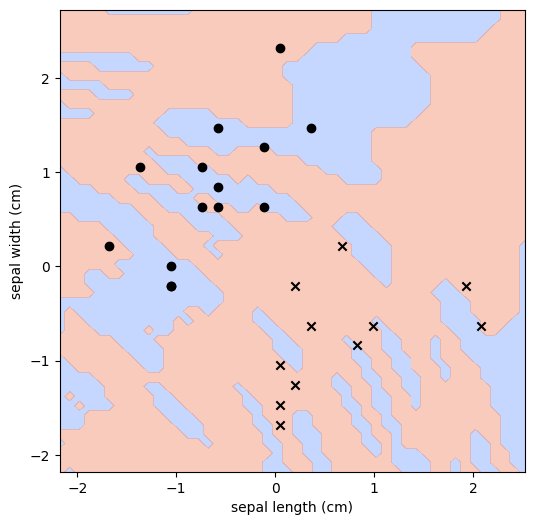

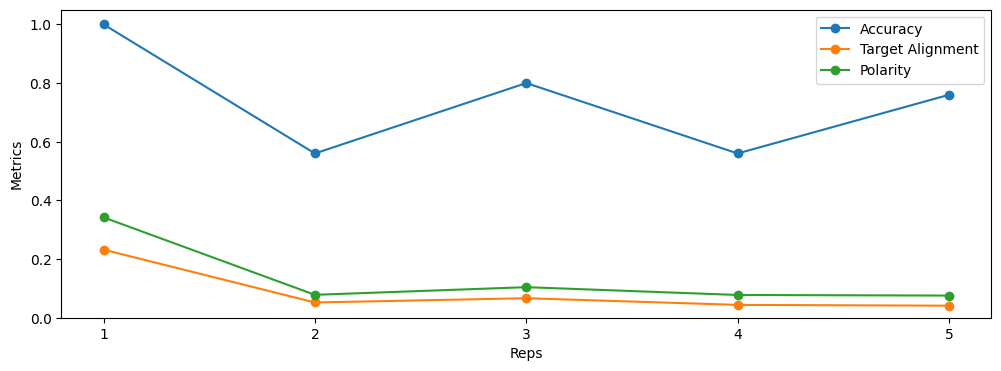

In [18]:
reps_list = []
accuracy_list = []
target_alignment_list = []
polarity_list = []

for reps in range(1, 6):
    print(f"******************* {reps} *******************")

    kernel_params = KernelParams(
        n_qubits=n_qubits,
        feature_map=FEATURE_MAP,
        reps=reps,
        kernel=kernel_with_qnode,
        rotaion_axis=None
    )

    train_kernel = compute_kernel(x_train, x_train, kernel_params)
    test_kernel = compute_kernel(x_test, x_train, kernel_params)

    model = SVC(kernel="precomputed")
    model.fit(train_kernel, y_train)
    y_pred = model.predict(test_kernel)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    plot_predicted_result(
        dataset, 
        y_pred, 
        save_path=f"{SAVE_IMG_DIRC}/reps{reps}_predict.png"
        )
    
    plot_decisionon_boundaries(
        model, 
        dataset,
        kernel_params,
        step_size=0.1, 
        save_path=f"{SAVE_IMG_DIRC}/reps{reps}_boundary.png"
    )

    target_alignment, polarity = evaluate_kernel(x_train, y_train, kernel_params)

    reps_list.append(reps)
    accuracy_list.append(accuracy)
    target_alignment_list.append(target_alignment)
    polarity_list.append(polarity)


plot_metrics(
    reps_list, 
    accuracy_list, 
    target_alignment_list, 
    polarity_list, 
    save_path=f"{SAVE_IMG_DIRC}/reps_metrics.png"
    )